# Анализ результатов АБ-теста

## Task 1
В данном задании вам нужно будет:

* проанализировать АБ тест, проведенный на реальных пользователях Яндекса
* подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
* определить характер этих изменений и практическую значимость вводимого изменения
* понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)

Описание данных:

* userID: уникальный идентификатор пользователя
* browser: браузер, который использовал userID
* slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
* n_clicks: количество кликов, которые пользоваль совершил за n_queries
* n_queries: количество запросов, который совершил userID, пользуясь браузером browser
* n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

Данные находятся в файле **ab_browser_test.csv**.

Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки.

In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('datasets/ab_browser_test.csv')
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566134 entries, 0 to 566133
Data columns (total 6 columns):
userID              566134 non-null int64
browser             566134 non-null object
slot                566134 non-null object
n_clicks            566134 non-null int64
n_queries           566134 non-null int64
n_nonclk_queries    566134 non-null int64
dtypes: int64(4), object(2)
memory usage: 25.9+ MB


In [4]:
sum_exp_clicks = data[data.slot == 'exp'].n_clicks.sum() 
sum_exp_clicks

3261823

In [5]:
sum_control_clicks = data[data.slot == 'control'].n_clicks.sum() 
sum_control_clicks

3210027

In [6]:
print(round((sum_exp_clicks - sum_control_clicks) / sum_control_clicks * 100, 3))

1.614


## Task 2
Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения.

1. 95% доверительный интервал для разности средних содержит ноль, похоже, средние существенно не отличаются
2. Применение bootstrap на выборках такого большого размера неправомерно, потому что bootstrap делает псведовыборки с возвращениями, а с ростом объема исходной выборки псведовыборки с возвращениями становятся более похожими на псведовыборки без возвращения.
3. 95% доверительный интервал для разности медиан не содержит ноль, похоже, медианы отличаются статистически значимо
4. 95% доверительный интервал для разности медиан содержит ноль, похоже, медианы существенно не отличаются
5. 95% доверительный интервал для разности средних не содержит ноль, похоже, средние отличаются статистически значимо

In [7]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [8]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [9]:
exp_clicks = data[data.slot == 'exp'].n_clicks.values
control_clicks = data[data.slot == 'control'].n_clicks.values

Доверительные интервалы для средних:

In [10]:
mean_exp_samples = list(map(np.mean, get_bootstrap_samples(exp_clicks, 500)))
mean_control_samples = list(map(np.mean, get_bootstrap_samples(control_clicks, 500)))

In [11]:
print('95% доверительный интервал среднего для тестовой выборки:', stat_intervals(mean_exp_samples, 0.05))
print('95% доверительный интервал среднего для контрольной выборки:', stat_intervals(mean_control_samples, 0.05))

95% доверительный интервал среднего для тестовой выборки: [11.50815665 11.66123304]
95% доверительный интервал среднего для контрольной выборки: [11.20781925 11.36450858]


Доверительные интервалы для медиан:

In [12]:
med_exp_samples = list(map(np.median, get_bootstrap_samples(exp_clicks, 500)))
med_control_samples = list(map(np.median, get_bootstrap_samples(control_clicks, 500)))

In [13]:
print('95% доверительный интервал медианы для тестовой выборки:', stat_intervals(med_exp_samples, 0.05))
print('95% доверительный интервал медианы для контрольной выборки:', stat_intervals(med_control_samples, 0.05))

95% доверительный интервал медианы для тестовой выборки: [5. 5.]
95% доверительный интервал медианы для контрольной выборки: [4. 4.]


Доверительные интервалы для разности средних и медиан:

In [14]:
delta_mean_samples = list(map(lambda x: x[0] - x[1], zip(mean_exp_samples, mean_control_samples)))
delta_med_samples = list(map(lambda x: x[0] - x[1], zip(med_exp_samples, med_control_samples)))

In [15]:
print('95% доверительный интервал разности средних:', stat_intervals(delta_mean_samples, 0.05))
print('95% доверительный интервал разности медиан:', stat_intervals(delta_med_samples, 0.05))

95% доверительный интервал разности средних: [0.19128296 0.41571787]
95% доверительный интервал разности медиан: [1. 1.]


**Ответ:** 3, 5

## Task 3
Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах.

1. Гипотезу о равенстве средних между двумя выборками можно проверить с помощью построения доверительного интервала для среднего объединенной выборки, потому что в силу большого объема выборки этот интервал будет очень точным, и мы сможем надежно оценить необходимый доверительный интервал
2. Для проверки гипотезы о равенстве средних в данной задаче можно использовать только параметрические критерии, потому что непараметрические, как известно, с увеличением размера выборки могут давать непредсказуемые результаты в силу случайности в определении их нулевого распределения.
3. Все ответы неверны
4. Используя центральную предельную теорему, мы можем заключить, что с ростом объема выборки любое исследуемое распределение, становится похожим на нормальное, а значит, учитывая большой объем нашей выборки, оптимальным критерием в нашей задаче будет z-критерий.
5. Для проверки гипотезы о равенстве средних категорически нельзя использовать t-критерий Стьюдента ни при каком размере выборки, потому что количество кликов, которые мы исследуем, больше походят на распределение Пуассона, которое сильно отличается от нормального.

**Ответ:** 3

## Task 4
t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных.

Для простоты рассмотрим одновыборочный t-критерий. Его статистика имеет вид $\frac{\bar{X} - \mu}{ \sqrt {S^2 / n}}$, то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

* $\overline{X}$ — среднее значение в выборке — было распределено нормально $N(\mu,\frac{\sigma^2}{n})$
* $\frac{n}{\sigma^2}S^2$ — несмещенная оценка дисперсии c масштабирующим коэффициентом — была распределена по хи-квадрат c n−1 степенями свободы $\chi^2(n−1)$

Простое доказательство необходимости и достаточности этого требования можно посмотреть в самом последнем абзаце этого вопроса. Усвоение этого доказательства не обязательно для выполнения задания.

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого

1. Получите из данных n_boot_samples псевдовыборок.
2. По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)
3. Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения
4. Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения с помощью команды **scipy.stats.probplot(control_boot_chi_squared, dist="chi2", sparams=(n-1), plot=plt)**

Где sparams=(n-1) означают число степеней свободы = длине выборки - 1.

Чтобы получить такой же ответ, как у нас, зафиксируйте seed и количество псевдовыборок: **np.random.seed(0); n_boot_samples = 500**

В качестве ответа отметьте верные утвердения о значениях $R^2$, которые генерирует **scipy.stats.probplot** при отображении qq-графиков: одно c графика для среднего и одно с графика для выборочной суммы квадратов отклонения от выборочной суммы.

1. $R^2$ для выборочной суммы квадратов отклонения от выборочной суммы получился больше, чем 0.99
2. $R^2$ для выборочной суммы квадратов отклонения от выборочной суммы получился меньше, чем 0.99
3. $R^2$ для выборочного среднего получился меньше, чем 0.99
4. $R^2$ для выборочного среднего получился больше, чем 0.99

In [16]:
np.random.seed(0)
n_boost_samples = get_bootstrap_samples(control_clicks, 500)

In [17]:
means = n_boost_samples.mean(axis=1)

In [32]:
chi_squares = [np.sum(sample**2) for sample in (n_boost_samples - means.reshape(500, 1))]

In [24]:
from scipy.stats import probplot
import matplotlib.pyplot as plt
%matplotlib inline

R^2 для выборочного среднего: 0.9959537742082024


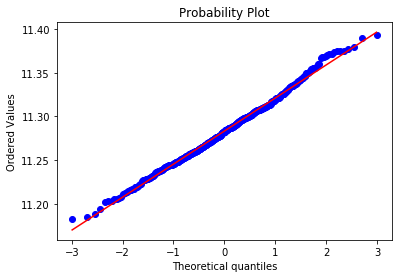

In [30]:
_, (_slope, _intercept, r) = probplot(means, plot=plt)
print('R^2 для выборочного среднего:', r**2)

R^2 для выборочного среднего: 0.9972851848247715


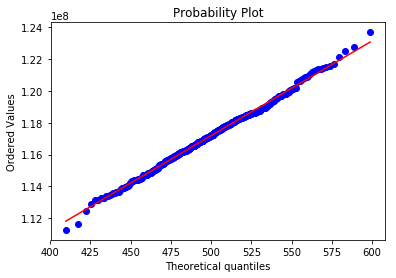

In [33]:
_, (_slope, _intercept, r) = probplot(chi_squares, dist='chi2', sparams=(len(chi_square)-1), plot=plt)
print('R^2 для выборочного среднего:', r**2)

**Ответ:** 1, 4

#### Почему мы проверяем именно такие условия?

В исходной постановке t-критерий требует нормальности распределения $X_i$ . Именно из-за этого предположения мы имеем, что $\sum_i X_i \sim \mathcal{N}(n \mu, n\sigma^2 )$ в силу линейности матожидания, независимости всех $X_i$ между собой и того факта, что сумма нескольких нормальных случайных величин также нормальна.

Поэтому, пользуясь опять формальными свойствами матожидания и дисперсии можем записать, что $\frac{1}{n} \sum_i X_i - \mu ~\sim~ \mathcal{N}(0, \frac{\sigma^2}{n} )$

Заметим теперь, что следующие распределения эквивалентны $\mathcal{N} (0, \frac{\sigma^2}{n}) \sim \sqrt{\frac{\sigma^2}{n}} \mathcal{N}(0, 1)$

То есть другими словами мы получили, что исходная статистика $\frac{\bar{X} - \mu}{ \sqrt {S^2 / n}}$ распределена как $\frac{ \mathcal{N}(0, 1) } { \sqrt { \frac{S^2n} { n \sigma^2} } } ~\sim~ \frac{ \mathcal{N}(0, 1) } { \sqrt { \frac{S^2} { \sigma^2} } }$  

Вспомним, что распределение Стьюдента с $n-1$ степенями свободы определяется как $\frac{ \mathcal{N}(0, 1) } { \sqrt { \chi^2 / (n-1) } }$. Поэтому и требования, которые накладываются, имеют вид, указанный в начале этого вопроса.

Полезно, однако, заметить, что можно подставить в числитель и знаменатель любые случайные величины, распределенные по нормальному закону и по Хи-квадрат соответственно, для этого необязательно, чтобы именно $X_i$ были распределены нормально. Поэтому, если мы убедимся в том, что, действительно, числитель и знаменатель распределены образом, указанным выше, то можно смело использовать t-критерий Стьюдента.

## Task 5
Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы:

1. Критерий Манна-Уитни в данной задаче применять нельзя, поэтому вопрос о достигаемом уровне значимости некорректен
2. Получившееся значение достигаемого уровня значимости свидетельствует о статистической значимости отличий между двумя выборками
3. $p < 0.01$, поэтому можно сказать, что отличия незначительны на уровне доверия 0.05
4. Согласно полученному значению p-value, мы вынуждены принять нулевую гипотезу

In [34]:
from scipy.stats import mannwhitneyu

In [43]:
exp_user_clicks = data[data.slot == 'exp'].groupby('userID')['n_clicks'].sum()
control_user_clicks = data[data.slot == 'control'].groupby('userID')['n_clicks'].sum()

In [44]:
mannwhitneyu(exp_user_clicks, control_user_clicks)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

**Ответ:** 2

## Task 6
Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с $\alpha=0.05$.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [82]:
from statsmodels.stats.multitest import multipletests

In [45]:
exp_browser_clicks = data[data.slot == 'exp'].groupby('browser')['n_clicks'].sum()
control_browser_clicks = data[data.slot == 'control'].groupby('browser')['n_clicks'].sum()

In [46]:
exp_browser_clicks

browser
Browser #14     294556
Browser #17     266285
Browser #2      560109
Browser #20     223212
Browser #22     858666
Browser #4     1058995
Name: n_clicks, dtype: int64

In [56]:
control_browser_clicks

browser
Browser #14     207229
Browser #17     266732
Browser #2      565964
Browser #20     225897
Browser #22     879810
Browser #4     1064395
Name: n_clicks, dtype: int64

In [116]:
p_values = [mannwhitneyu(data[(data.browser == browser) & (data.slot == 'exp')].n_clicks, 
                         data[(data.browser == browser) & (data.slot == 'control')].n_clicks).pvalue 
            for browser in data.browser.unique()]
p_values

[0.0272438604197241,
 0.40760617658454984,
 0.0,
 0.03740060143010802,
 0.45366656388735377,
 0.2574055152210032]

$H_0$ - гипотеза, что отличий в кликах в эксперементальной и контрольной группах нет

In [115]:
rejected = multipletests(p_values, alpha=0.05, method='holm')[0]
for browser, status in zip(data.browser.unique(), rejected):
    print(f'for {browser} H_0', 'rejected' if status else 'not rejected')

for Browser #2 H_0 not rejected
for Browser #4 H_0 not rejected
for Browser #14 H_0 rejected
for Browser #17 H_0 not rejected
for Browser #20 H_0 not rejected
for Browser #22 H_0 not rejected


**Ответ:** 5. Можно сделать вывод, что только на пользователей одного браузера новая функциональность действует положительно.

## Task 7

Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения:
1. По всем браузерам мы видим незначительное уменьшение доли некликнутых запросов, поэтому делаем вывод о том, что тестируемое изменение приносит больше вреда, чем пользы.
2. По одному из браузеров мы видим значительное уменьшение доли некликнутых запросов, поэтому уже только на этом основании тестируемое изменение можно рекомендовать к применению для всех пользователей.
3. С помощью анализа, проведенного в предыдущем вопросе, мы показали, что тестируемое изменение приводит к статистически значимому отличию только для одного браузера. Для этого браузера на основе данных о доли некликнутых запросов, заключаем, что тестируемое изменение влияет на пользователей позитивно.
4. Тестируемое изменение можно предложить к внедрению только на тот сегмент пользователей, где локализуется изменение, то есть для того браузера, для которого доля некликнутых запросов уменьшилась больше всего. Для прочих браузеров мы не обладаем никакой информацией относительно влияния тестируемого изменения на поведение пользователей.

In [84]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [105]:
exp_stat = data[data.slot == 'exp'].groupby('browser')[['n_queries', 'n_nonclk_queries']].sum()
exp_stat['non_clicked %'] = exp_stat.n_nonclk_queries / exp_stat.n_queries * 100
exp_stat

,n_queries,n_nonclk_queries,non_clicked %
browser,,,
Browser #14,282606,123656,43.755617
Browser #17,210123,77614,36.937413
Browser #2,548019,246514,44.982747
Browser #20,187283,72998,38.977376
Browser #22,743156,296177,39.853947
Browser #4,1011250,456508,45.142942


In [106]:
control_stat = data[data.slot == 'control'].groupby('browser')[['n_queries', 'n_nonclk_queries']].sum()
control_stat['non_clicked %'] = control_stat.n_nonclk_queries / control_stat.n_queries * 100
control_stat

,n_queries,n_nonclk_queries,non_clicked %
browser,,,
Browser #14,279998,161252,57.590411
Browser #17,208921,75837,36.299367
Browser #2,566239,260259,45.962747
Browser #20,193752,78548,40.540485
Browser #22,777135,315470,40.593977
Browser #4,1060771,498254,46.970930


**Ответ:** 3